### Import libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np

from iminuit import Minuit

from functools import partial
from numba import njit

from joblib import Parallel, delayed

import os, sys
sys.path.append(os.path.abspath('..'))

import constants, functions

### First Chi2 estimation for window

In [2]:
import pandas as pd
data_bao = pd.read_csv("../../data/DESIDR2/alpha_data.dat", sep=';', header=0)

z_data_bao = data_bao['zeff']
Dmrd_data = data_bao['DM/rd']
Dmrd_err = data_bao['DM/rd_err']

In [3]:
@njit
def chi2_rsd_bao(z_data_rsd, z_data_bao, fs8_data, fs8_err_plus, fs8_err_minus, dmrd_data, dmrd_err, c, omega, sigma, gamma, rd, H0):
    return functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + functions.chi2_bao_dmrd(z_data_bao, dmrd_data, dmrd_err, c, omega, rd, H0)

z_data_bao = np.asarray(constants.z_data_bao)
Dmrd_data = np.asarray(constants.Dmrd_data)
Dmrd_err = np.asarray(constants.Dmrd_err)

z_data_rsd = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)
c = constants.C

chi2_func = partial(
    chi2_rsd_bao,
    z_data_rsd,
    z_data_bao,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    Dmrd_data,
    Dmrd_err,
    c
)

In [7]:
N = 100
is_highres = False

n_om = N
n_H0 = N
n_rd = N
n_s8 = N
n_gamma = N

H0_min = 50
H0_max = 100

rd_min = 100
rd_max = 200

if is_highres:
    om_min = 0.250
    om_max = 0.5
    s8_min = 0.5
    s8_max = 1.05
    gamma_min = 0
    gamma_max = 1.2
    FOLDER = "highres"
else:
    om_min = .05
    om_max = 1
    s8_min = 0.4
    s8_max = 1.2
    gamma_min = -0.5
    gamma_max = 2
    FOLDER = "lowres"

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))
rd_vals = np.asarray(np.linspace(rd_min, rd_max, n_rd))
H0_vals = np.asarray(np.linspace(H0_min, H0_max, n_H0))

In [5]:
minimizer = Minuit(chi2_func, omega=0.315, sigma=0.811, gamma=0.55, rd=147, H0=73.4)

minimizer.limits["omega"] = (om_min, om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
# minimizer.fixed["gamma"] = True
# minimizer.fixed["sigma"] = True
# minimizer.limits["rd"] = (rd_min, rd_max)
minimizer.limits["H0"] = (H0_min, H0_max)
minimizer.fixed["rd"] = True
# minimizer.fixed["H0"] = True

result = minimizer.migrad()

print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.3f} ± {minimizer.errors['omega']:.4f}")
print(f"rd = {minimizer.values['rd']:.3f} ± {minimizer.errors['rd']:.4f}")
print(f"H0 = {minimizer.values['H0']:.3f} ± {minimizer.errors['H0']:.3f}\n")

print(result)


Résultats du fit :
Chi2 = 16.52 

Paramètres estimés :
Ωm = 0.317 ± 0.0308
rd = 147.000 ± 1.4700
H0 = 68.206 ± 1.205

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.52                      │              Nfcn = 132              │
│ EDM = 2.03e-06 (Goal: 0.0002)    │            time = 2.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────

### Calculations

In [8]:
from time import time
from scipy.integrate import quad
import math

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, rd = 147.05, H0 = 73.4)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, rd = 147.05, H0 = 73.4)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, rd = 147.05, H0 = 73.4)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.migrad()
    return minimizer.fval

t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

t = time()
chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_func) for omega in omega_vals for gamma in gamma_vals)
chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
t = time() - t
print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

t = time()
chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(sigma, gamma, om_min, om_max, chi2_func) for sigma in sigma_vals for gamma in gamma_vals)
chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
t = time() - t
print("chi2_grid 3 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 0 min 4.3 s.
chi2_grid 2 calculated in 0 min 3.8 s.
chi2_grid 3 calculated in 0 min 4.9 s.


In [9]:
np.savez("../../output/2-chi2_RSD_DESIDR2/" + FOLDER + "/chi2_grid1.npz", grid1=chi2_grid1)
np.savez("../../output/2-chi2_RSD_DESIDR2/" + FOLDER + "/chi2_grid2.npz", grid2=chi2_grid2)
np.savez("../../output/2-chi2_RSD_DESIDR2/" + FOLDER + "/chi2_grid3.npz", grid3=chi2_grid3)

### Plot

(100.0, 0.31868686868686863)
Incertitude $rd$ : xmin = 100, xmax = 200
Incertitude $\Omega_m$ : ymin = 0, ymax = 0

(92.92929292929293, 0.31868686868686863)
Incertitude $H0$ : xmin = 50, xmax = 100
Incertitude $\Omega_m$ : ymin = 0, ymax = 0

(63.131313131313135, 158.5858585858586)
Incertitude $rd$ : xmin = 50, xmax = 100
Incertitude $H0$ : ymin = 100, ymax = 200



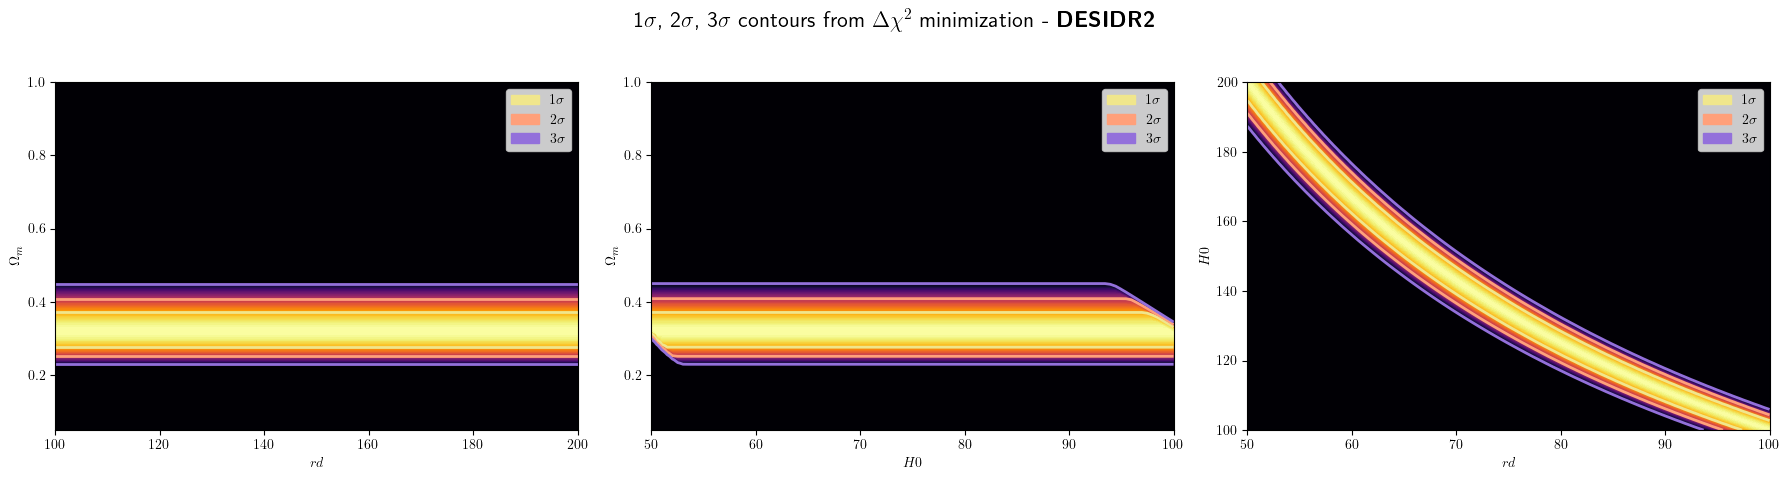

In [9]:
from matplotlib.patches import Patch

def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$rd$', r'$\Omega_m$', 0),
        (r'$H0$', r'$\Omega_m$', 1),
        (r'$rd$', r'$H0$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        
        rd_vals = np.asarray(np.linspace(rd_min, rd_max, chi2_grid.shape[0]))
        omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
        H0_vals = np.asarray(np.linspace(H0_min, H0_max, chi2_grid.shape[0]))

        if axis == 0:
            X, Y = np.meshgrid(rd_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(H0_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(H0_vals, rd_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.0f}, xmax = {xmax:.0f}")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.0f}, ymax = {ymax:.0f}\n")

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

plt.rcParams.update({
    "text.usetex": True
})
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{DESIDR2}$", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

(0.7444444444444445, 0.3181818181818182)
Incertitude $\sigma_8$ : xmin = 0.68, xmax = 0.82 : (+0.07, -0.07)
Incertitude $\Omega_m$ : ymin = 0.28, ymax = 0.37 : (+0.04, -0.05)

(0.48484848484848486, 0.3181818181818182)
Incertitude $\gamma$ : xmin = 0.32, xmax = 0.68 : (+0.17, -0.19)
Incertitude $\Omega_m$ : ymin = 0.28, ymax = 0.37 : (+0.04, -0.05)

(0.48484848484848486, 0.7444444444444445)
Incertitude $\gamma$ : xmin = 0.32, xmax = 0.68 : (+0.17, -0.19)
Incertitude $\sigma_8$ : ymin = 0.67, ymax = 0.82 : (+0.07, -0.07)



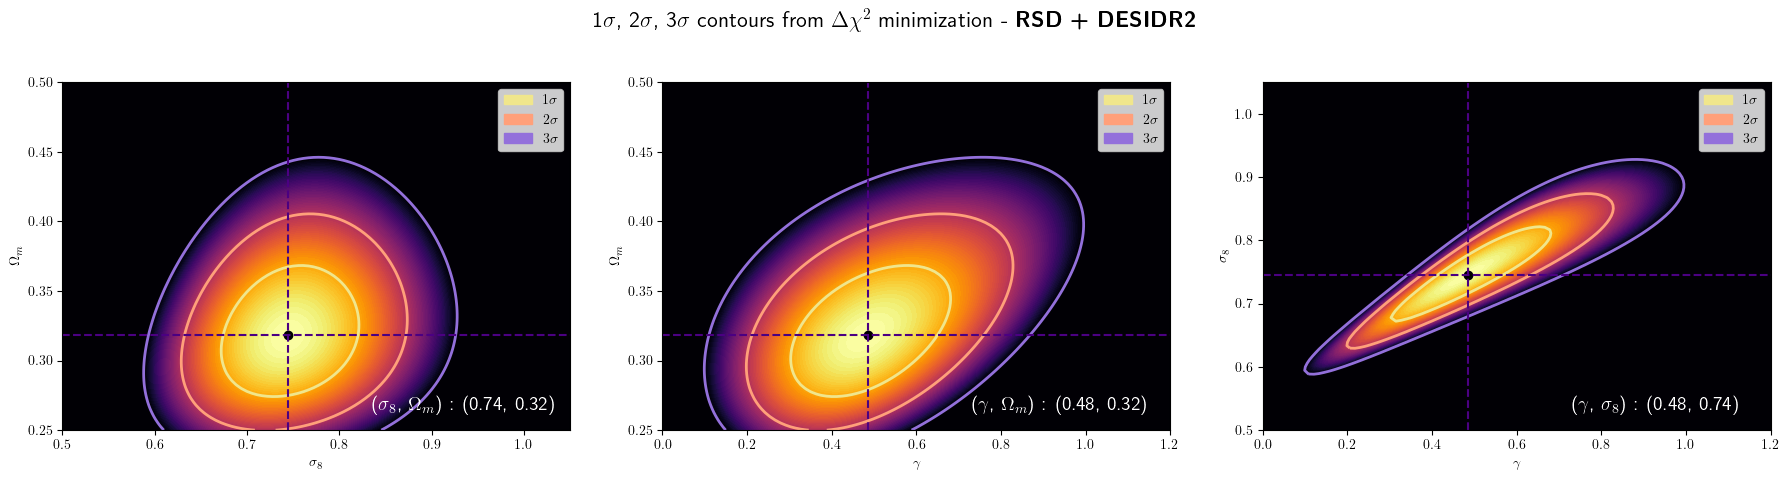

In [12]:
from matplotlib.patches import Patch
def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        
        sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[0]))
        omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
        gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[0]))

        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
                verticalalignment='top', horizontalalignment='left')

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

        ax.set_facecolor('black')

        # if axis == 0:
        #     ax.set_xlim([0.5, 1.03])
        #     ax.set_ylim([0.25, 0.47])
        # elif axis == 1:
        #     ax.set_xlim([-.1, 1.3])
        #     ax.set_ylim([0.23, 0.5])
        # elif axis == 2:
        #     ax.set_xlim([-0.1, 1.3])
        #     ax.set_ylim([0.5, 1.1])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({
    "text.usetex": True
})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{RSD + DESIDR2}$", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()